This Notebook is for generating visualizations across different features of our datasets. We analyse by different retail industries and also look at general distributions across features. We also compare different features against each other. In this notebook we look at the analysis without removing merchant outliers. We will compare the plots and findings from this notebook to the outlier_removal plots to see the effect of removing our outliers.

In [6]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [7]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())

df_pandas = df.toPandas()

+------------+--------------------+-------------+---------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+-----------------+------------------+------------------+---------------------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_order|average_spend_per_consumer|average_monthly_diff_consumers|consumer_d

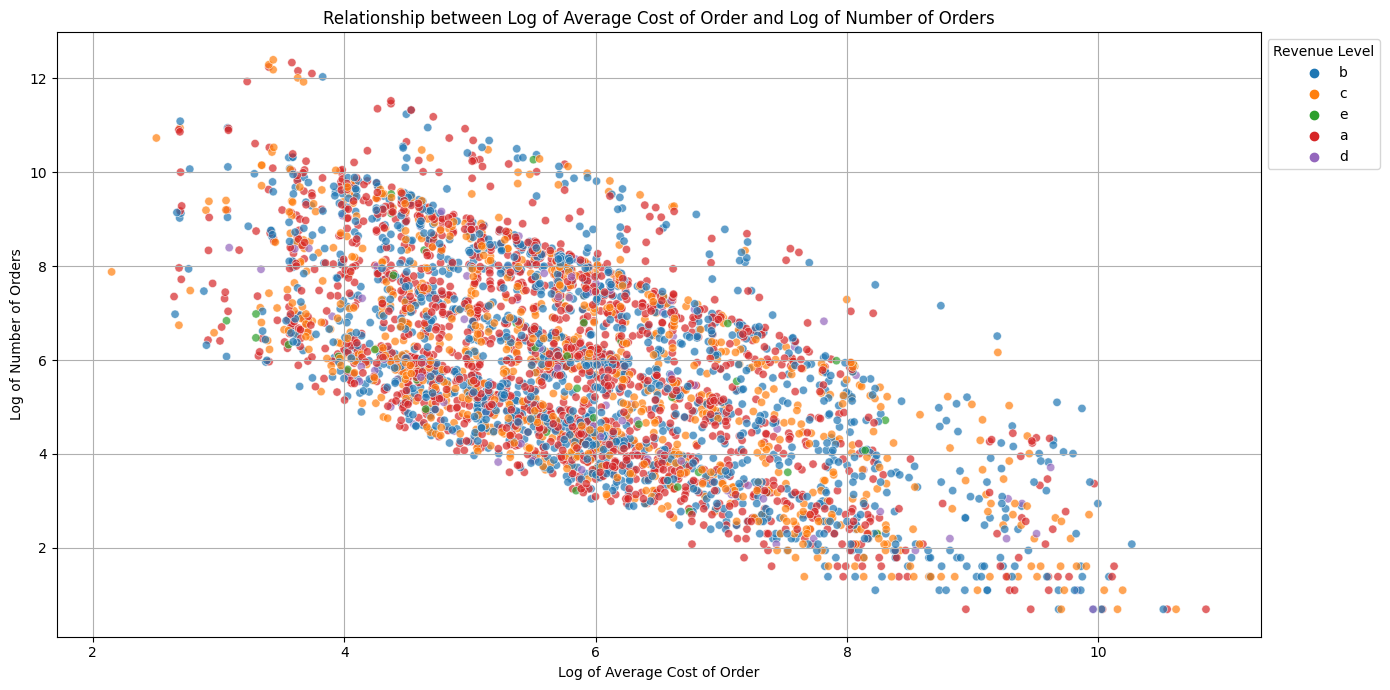

In [8]:
import seaborn as sns
from pyspark.sql.functions import log1p

df = df.withColumn('log_average_cost_of_order', log1p(df['average_cost_of_order']))
df = df.withColumn('log_number_of_orders', log1p(df['number_of_orders']))

# Convert the PySpark dataframe to a pandas dataframe for visualization
df_pandas = df.toPandas()

# Create the scatter plot with revenue_level as hue
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_pandas, x='log_average_cost_of_order', y='log_number_of_orders', hue='revenue_level', palette='tab10', alpha=0.7)
plt.title('Relationship between Log of Average Cost of Order and Log of Number of Orders')
plt.xlabel('Log of Average Cost of Order')
plt.ylabel('Log of Number of Orders')
plt.grid(True)
plt.legend(title='Revenue Level', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


Summary Statistics for average_consumer_fraud_probability:

count    3135.000000
mean        1.314906
std         4.332110
min         0.004561
25%         0.045017
50%         0.075769
75%         0.493818
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



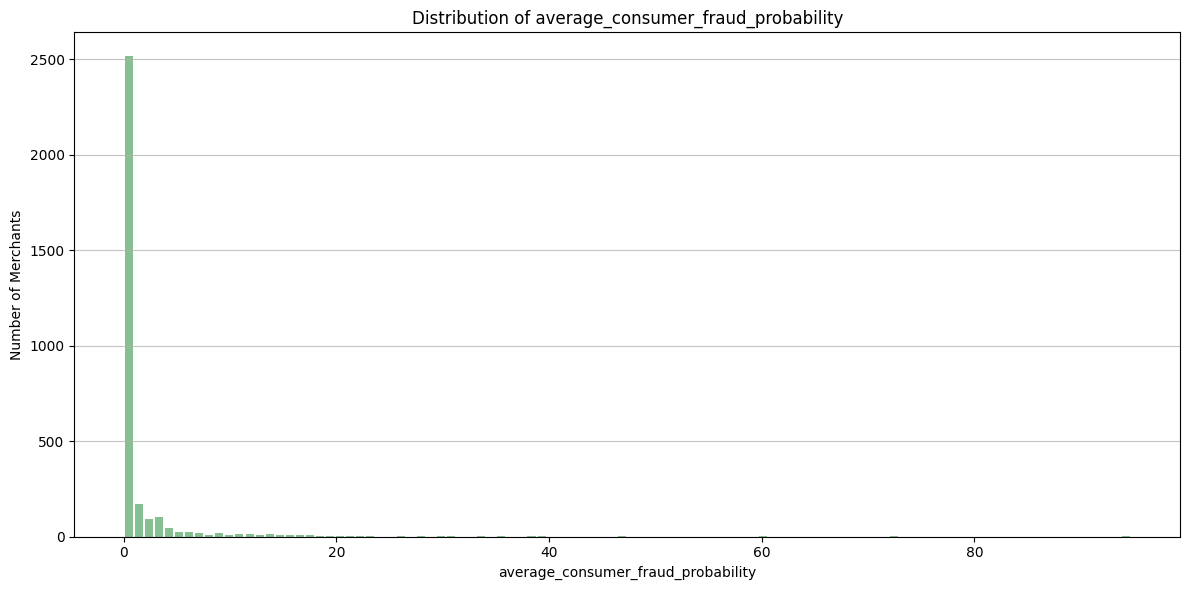

Summary Statistics for avg_median_age:

count    4026.000000
mean       43.112349
std         0.991092
min        26.000000
25%        42.913605
50%        43.107035
75%        43.300379
max        55.000000
Name: avg_median_age, dtype: float64

--------------------------------------------------



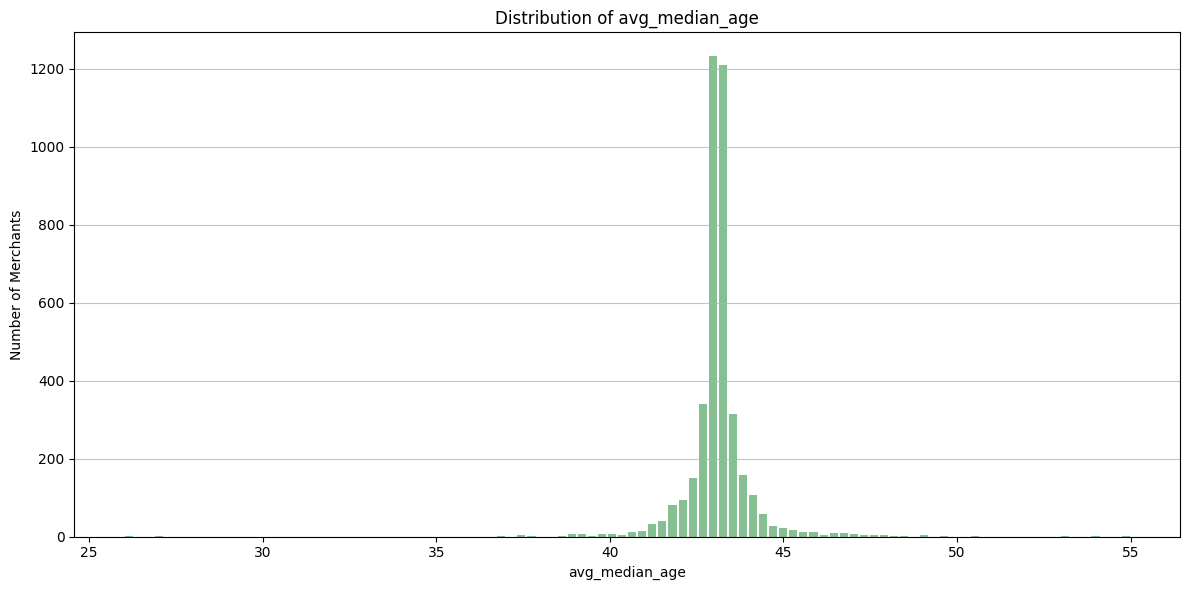

Summary Statistics for avg_total_weekly_personal_income:

count    4026.000000
mean      789.579167
std        30.273343
min       471.000000
25%       782.828468
50%       790.159310
75%       796.630394
max      1165.900000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



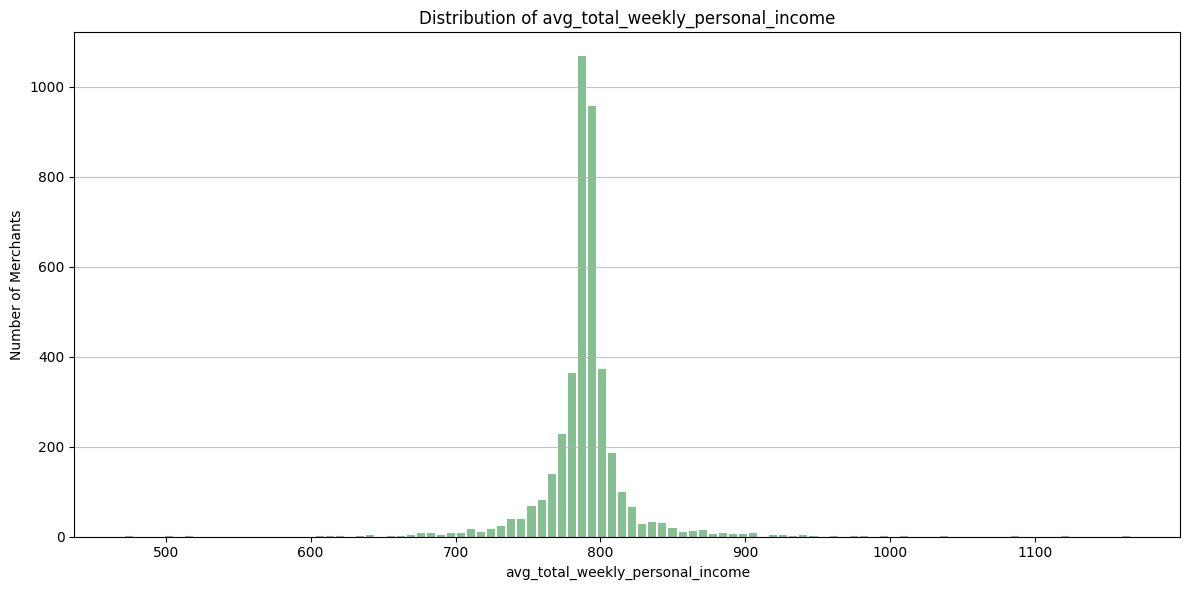

Summary Statistics for take_rate:

count    4026.000000
mean        4.397575
std         1.782595
min         0.100000
25%         2.970000
50%         4.500000
75%         6.030000
max         7.000000
Name: take_rate, dtype: float64

--------------------------------------------------



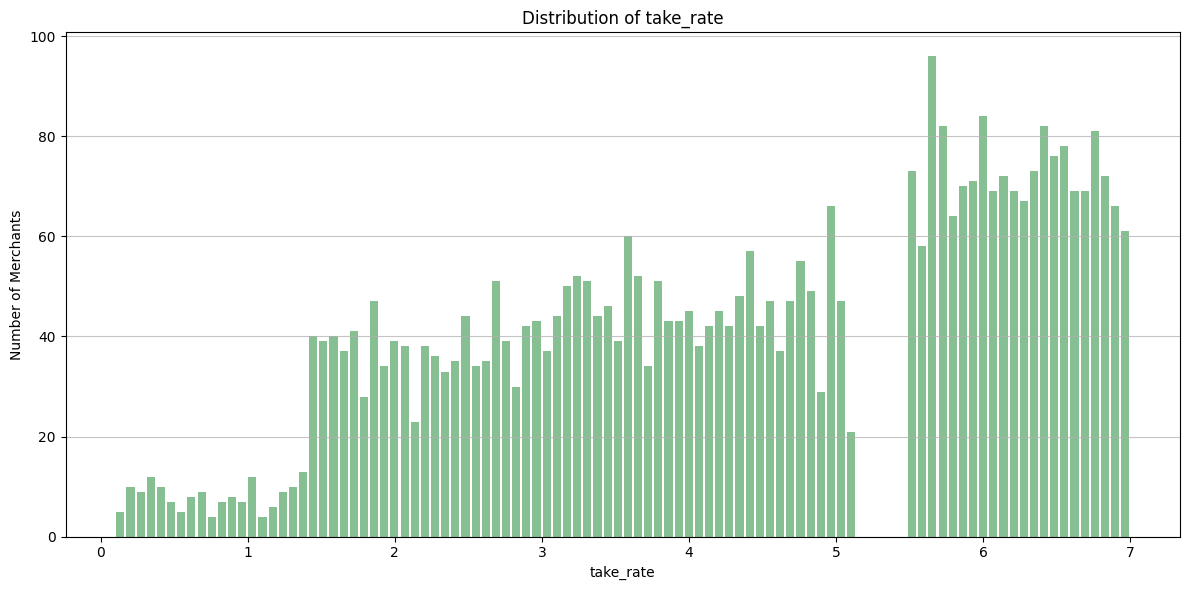

Summary Statistics for average_cost_of_order:

count     4026.000000
mean      1162.394858
std       2972.212606
min          7.579026
25%        118.295487
50%        317.551494
75%        841.489967
max      51876.640000
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



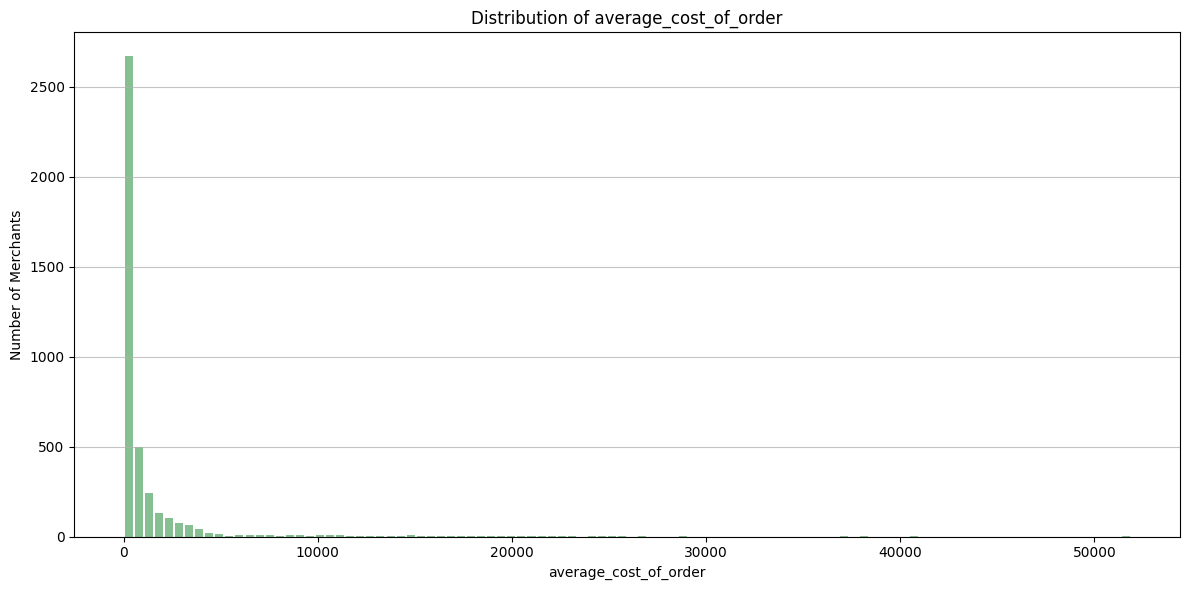

Summary Statistics for number_of_orders:

count      4026.000000
mean       2824.824888
std       11816.655769
min           1.000000
25%          78.250000
50%         352.000000
75%        1718.500000
max      241547.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



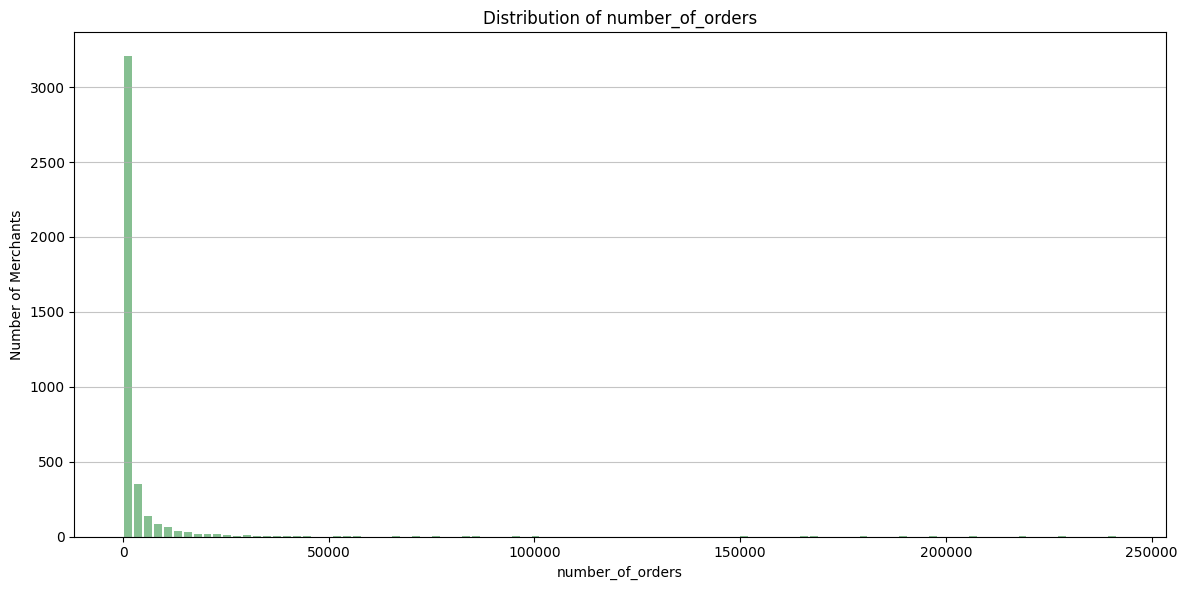

Summary Statistics for number_of_unique_consumers:

count     4026.000000
mean      1691.663189
std       3236.959538
min          1.000000
25%         78.250000
50%        349.000000
75%       1643.500000
max      20115.000000
Name: number_of_unique_consumers, dtype: float64

--------------------------------------------------



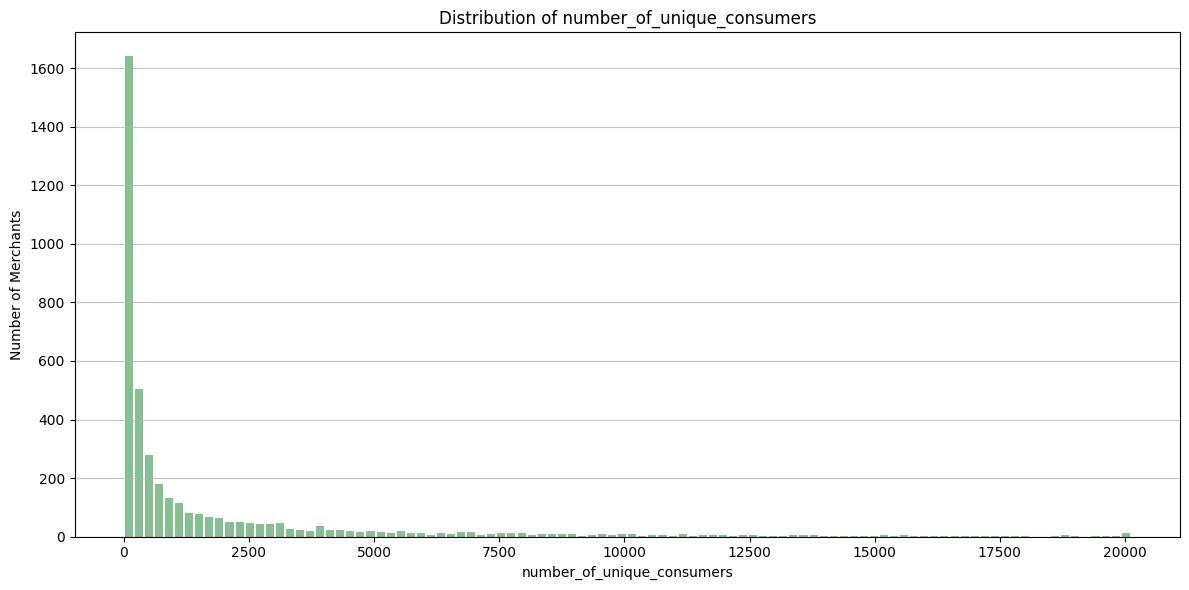

Summary Statistics for average_merchant_fraud_probability:

count    47.000000
mean      1.313311
std       2.898382
min       0.125353
25%       0.259682
50%       0.724312
75%       1.153219
max      18.210900
Name: average_merchant_fraud_probability, dtype: float64

--------------------------------------------------



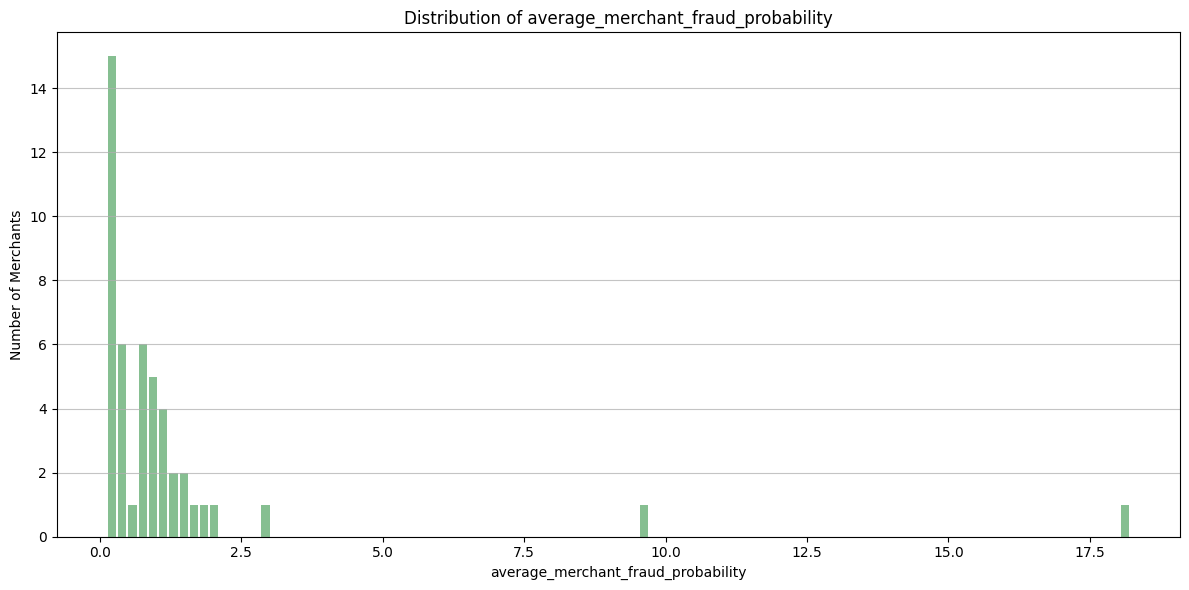

Summary Statistics for average_consumer_fraud_probability:

count    3135.000000
mean        1.314906
std         4.332110
min         0.004561
25%         0.045017
50%         0.075769
75%         0.493818
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



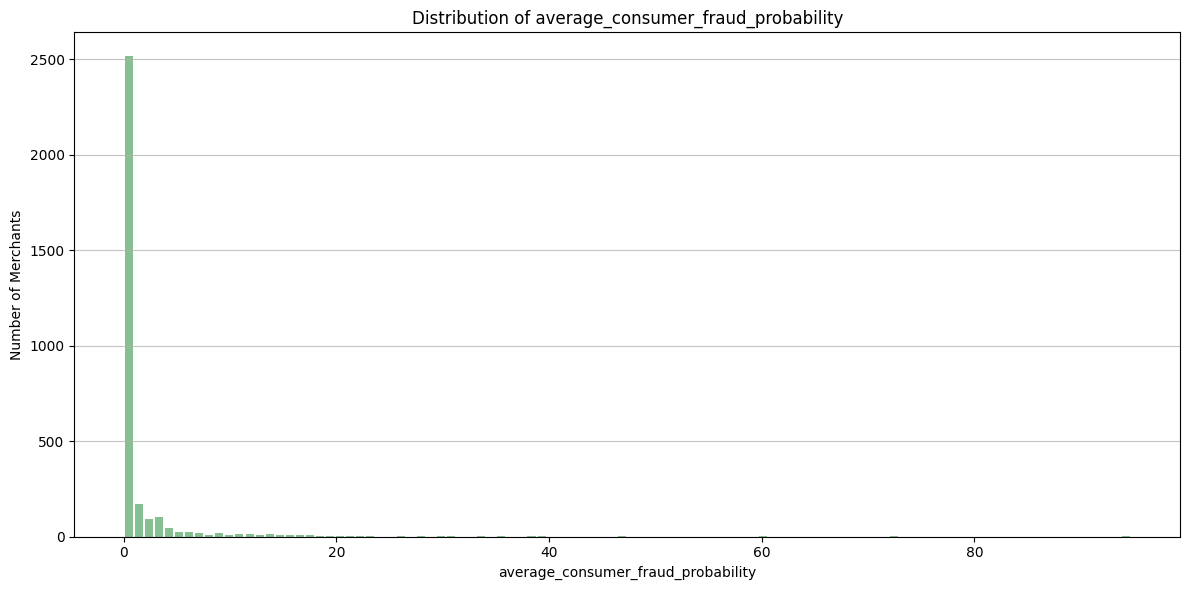

In [10]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_of_unique_consumers",
    "average_merchant_fraud_probability",
    "average_consumer_fraud_probability", 
]

df_pandas = df.toPandas()
# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    filtered_df = df.filter(
    (F.col(column) > 0) 
)   
    df_pandas = filtered_df.toPandas()
    # Calculate Summary Statistics
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


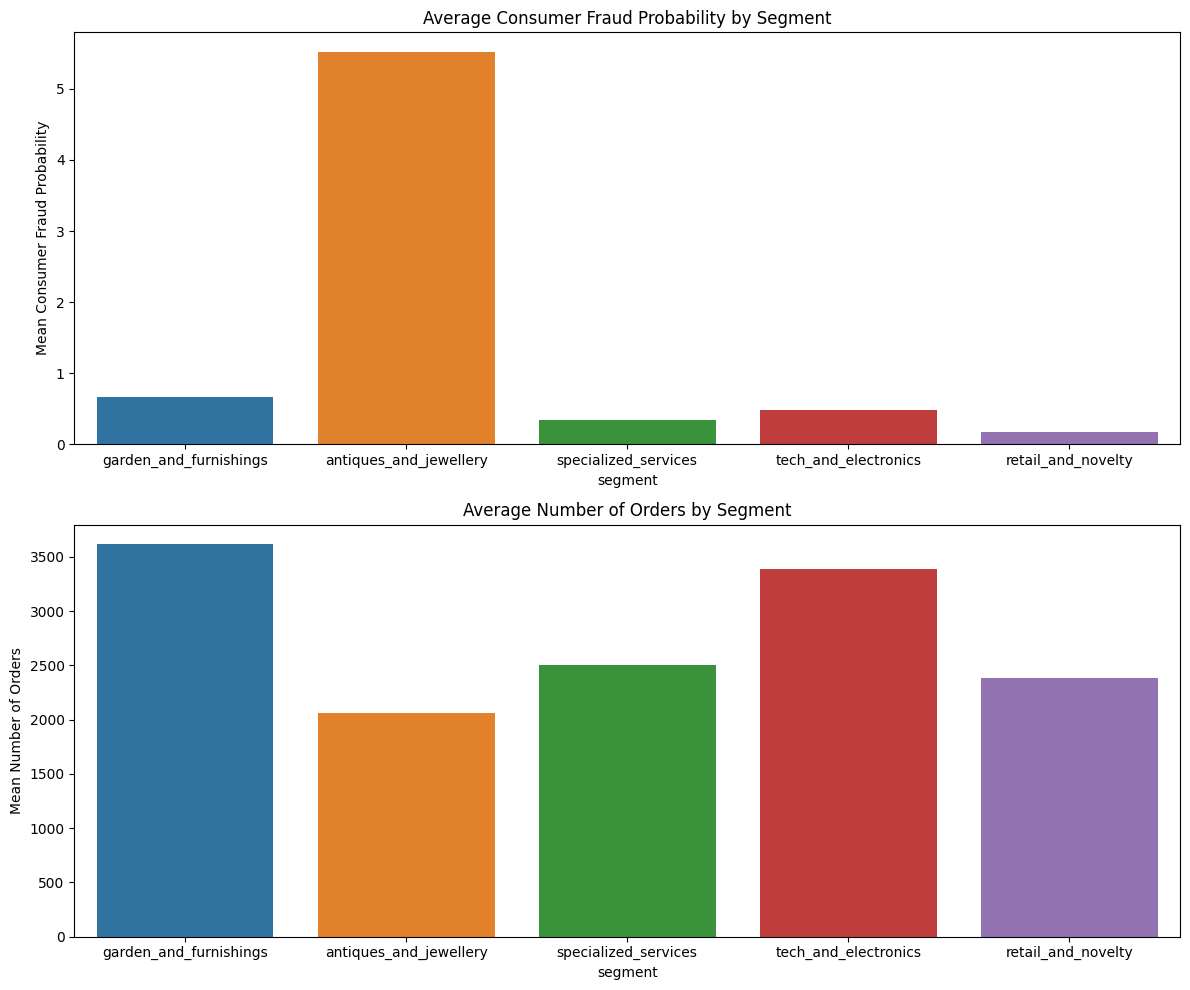

In [11]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Group by segment and aggregate the mean and standard deviation
agg_data = df.groupBy("segment").agg(
    F.mean("average_consumer_fraud_probability").alias("mean_consumer_fraud"),
    F.stddev("average_consumer_fraud_probability").alias("stddev_consumer_fraud"),
    F.mean("number_of_orders").alias("mean_orders"),
    F.stddev("number_of_orders").alias("stddev_orders")
)

# Convert the aggregated data to Pandas DataFrame for visualization
agg_data_pandas = agg_data.toPandas()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Average consumer fraud probability by segment
sns.barplot(x="segment", y="mean_consumer_fraud", data=agg_data_pandas, ax=axes[0])
axes[0].set_title('Average Consumer Fraud Probability by Segment')
axes[0].set_ylabel('Mean Consumer Fraud Probability')

# Number of orders by segment
sns.barplot(x="segment", y="mean_orders", data=agg_data_pandas, ax=axes[1])
axes[1].set_title('Average Number of Orders by Segment')
axes[1].set_ylabel('Mean Number of Orders')

plt.tight_layout()
plt.show()


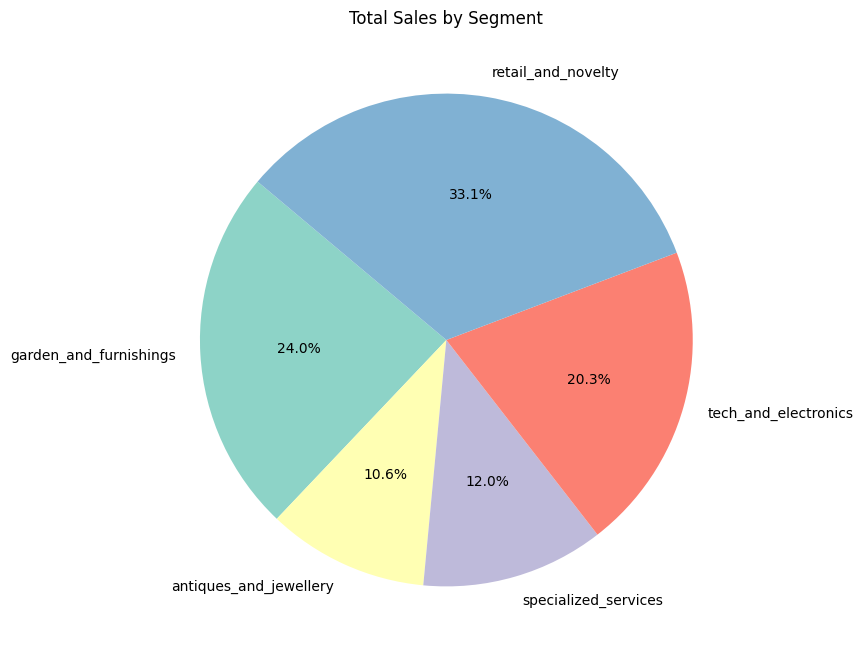

In [12]:
# Group by segment and aggregate total sales for each segment
agg_sales = df.groupBy("segment").agg(
    F.sum(df.number_of_orders * df.average_cost_of_order).alias("total_sales")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
sales_pandas = agg_sales.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(sales_pandas["total_sales"], labels=sales_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(sales_pandas)))
plt.title('Total Sales by Segment')
plt.show()


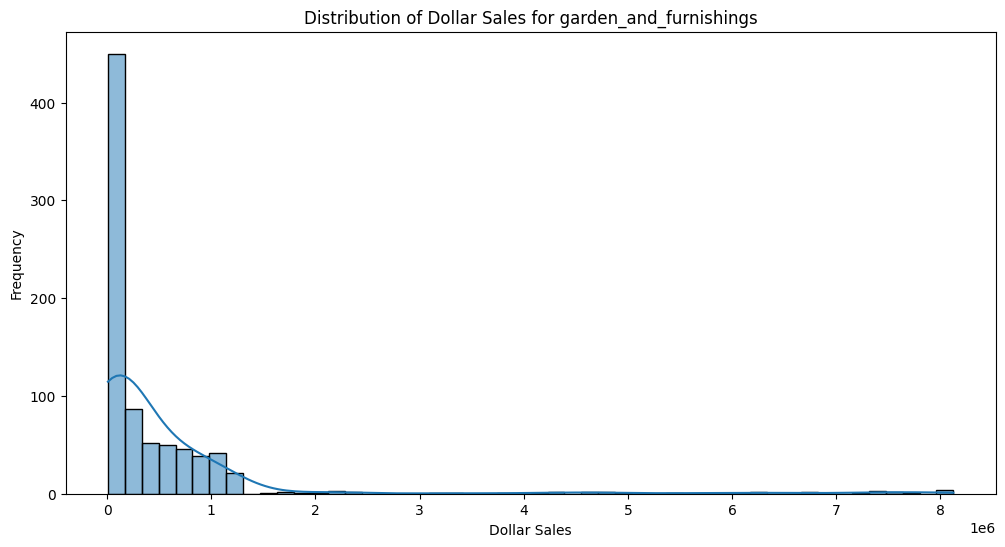

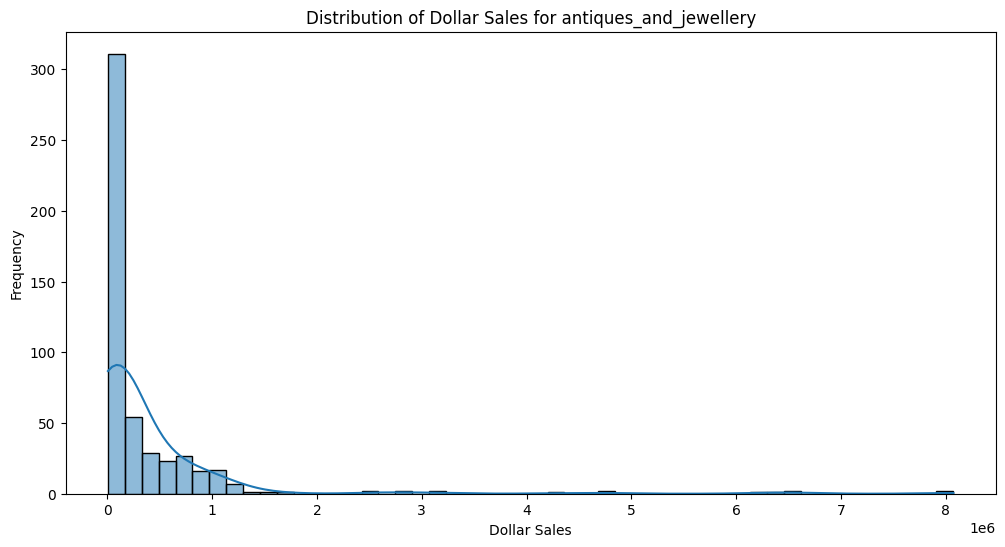

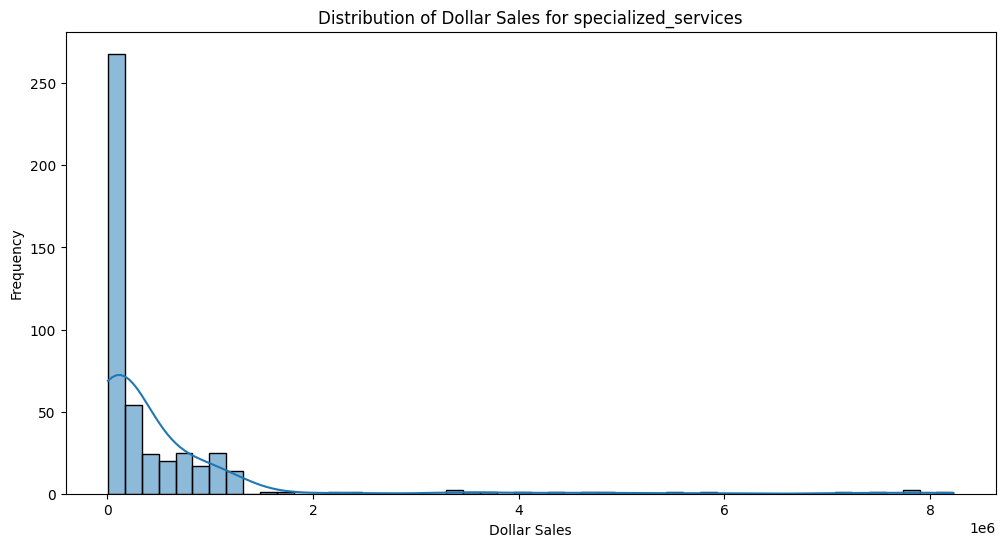

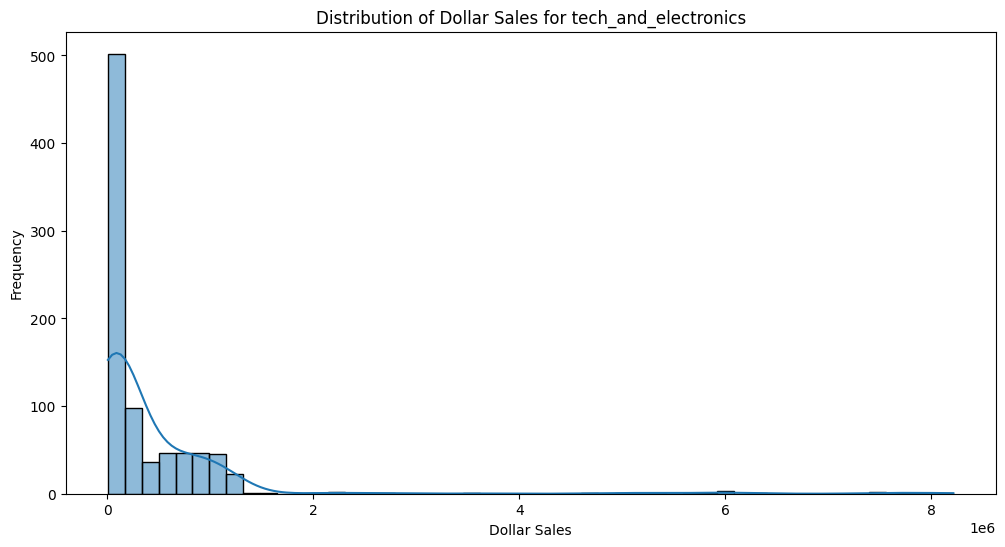

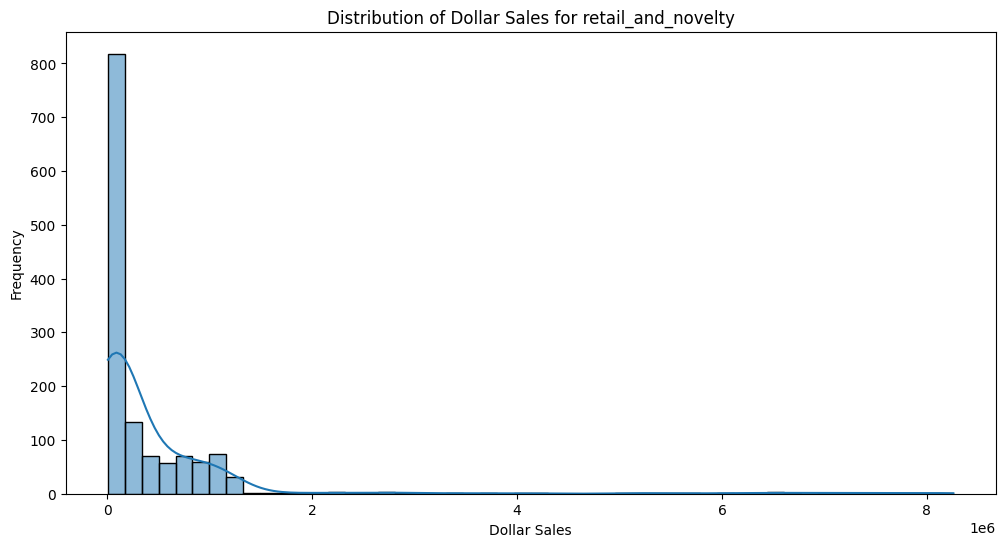

In [13]:
segments = df.select("segment").distinct().rdd.flatMap(lambda x: x).collect()

for segment in segments:
    segment_df = df.filter(df.segment == segment)
    
    # Check if the segment dataframe is not empty
    if segment_df.count() > 0:
        segment_df = segment_df.withColumn("dollar_sales", col("average_cost_of_order") * col("number_of_orders"))


        plt.figure(figsize=(12, 6))
        segment_df_pandas = segment_df.toPandas()
        sns.histplot(segment_df_pandas['dollar_sales'], kde=True, bins=50)
        plt.title(f'Distribution of Dollar Sales for {segment}')
        plt.xlabel('Dollar Sales')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"No data for segment: {segment}")


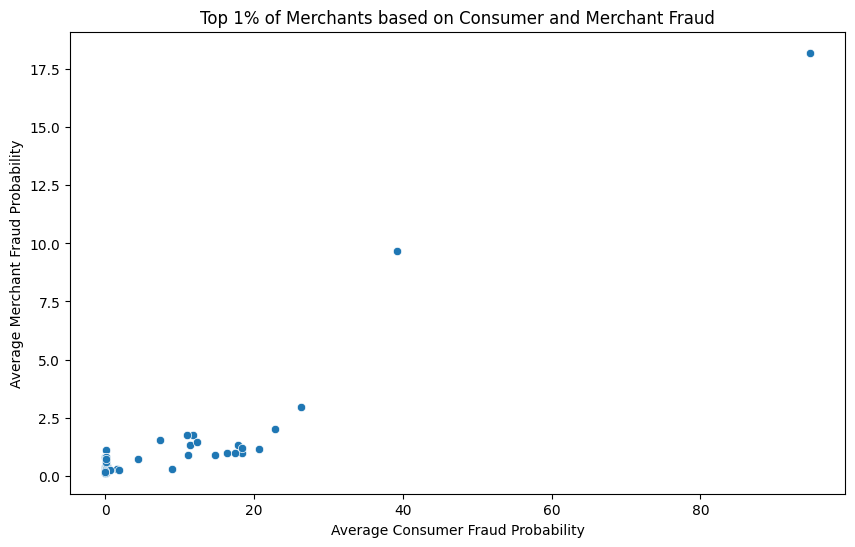

In [30]:
consumer_fraud_threshold = df.approxQuantile("average_consumer_fraud_probability", [0.5], 0.5)[0]
merchant_fraud_threshold = df.approxQuantile("average_merchant_fraud_probability", [0.5], 0.5)[0]

# 2. Filter the DataFrame
filtered_df = df.filter((col("average_consumer_fraud_probability") > consumer_fraud_threshold) & 
                        (col("average_merchant_fraud_probability") > merchant_fraud_threshold))

# 3. Plotting
filtered_df_pandas = filtered_df.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df_pandas, x="average_consumer_fraud_probability", y="average_merchant_fraud_probability")
plt.title("Top 1% of Merchants based on Consumer and Merchant Fraud")
plt.xlabel("Average Consumer Fraud Probability")
plt.ylabel("Average Merchant Fraud Probability")
plt.show()